## Download and become one with the data

In [ ]:
# Get data (10% of food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-23 13:22:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   104MB/s    in 1.6s    

2021-09-23 13:22:24 (104 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through the directory
for dir_path, dir_names, file_names in os.walk("10_food_classes_10_percent"):
  print("There are " + str(len(dir_names)) + "  directories and " + str(len(file_names)) + " images in " + dir_path)

There are 2  directories and 0 images in 10_food_classes_10_percent
There are 10  directories and 0 images in 10_food_classes_10_percent/train
There are 0  directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0  directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0  directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0  directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0  directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0  directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0  directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0  directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0  directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0  directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are

## Creating data loaders (preparing the data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [ ]:
# Create a TensorBoard callback function
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print("Saving TensorBoard log files on: " + log_dir)

  return tensorboard_callback 

## Creating models using TensorFlow Hub

In [ ]:
mobilenetv2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Cerate our model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation="softmax")                    
  ])

  return model

## Creating and testing Mobilenetv2 TensorFlow Hub Extraction model

In [ ]:
# Create MobileNetv2 model
mobilenet_model = create_model(mobilenetv2_url, 
                               num_classes=train_data.num_classes)

In [ ]:
mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Compile our model
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer="Adam",
                        metrics=["accuracy"])

In [ ]:
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=EPOCHS,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobilenetV2")])

Saving TensorBoard log files on: tensorflow_hub/mobilenetV220210923-133055
Epoch 1/5
24/24 [==============================] - 24s 854ms/step - loss: 2.0631 - accuracy: 0.2920 - val_loss: 1.3855 - val_accuracy: 0.5816
Epoch 2/5
24/24 [==============================] - 18s 769ms/step - loss: 1.0691 - accuracy: 0.7000 - val_loss: 0.9003 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 17s 744ms/step - loss: 0.7370 - accuracy: 0.7893 - val_loss: 0.7676 - val_accuracy: 0.7768
Epoch 4/5
24/24 [==============================] - 17s 748ms/step - loss: 0.5903 - accuracy: 0.8560 - val_loss: 0.6947 - val_accuracy: 0.7936
Epoch 5/5
24/24 [==============================] - 17s 746ms/step - loss: 0.4857 - accuracy: 0.8827 - val_loss: 0.6447 - val_accuracy: 0.8100


In [ ]:
# Creating a function to plot the loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns sepereate loss ruves for training and validation metrics

  Args:
    history: TensorFlow history object

  Returns:
    Plots of training/validatio loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, loss, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

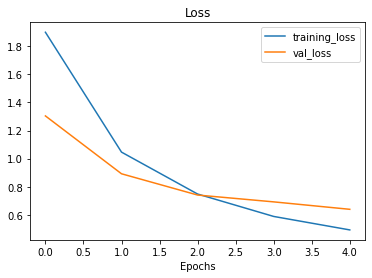

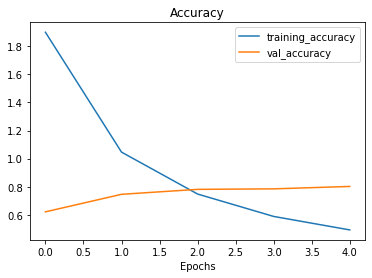

In [ ]:
plot_loss_curves(mobilenet_history)